# Transport models in BioCRNpyler
## Integration of membrane protein, transport of substrates, and two-component sensing using BioCRNpyler membrane components and mechanism
Consider the following substrate transport steps:
1. Expression of membrane protein: G + EnergyTXTL $\rightarrow$ membrane_protein (MP)
2. Integration of membrane protein in membrane: MP $\rightarrow$ integral_membrane_protein (IMP)
3. Diffusion, transport across membrane, or a memebrane sensor

Types of membrane transport mechanisms:
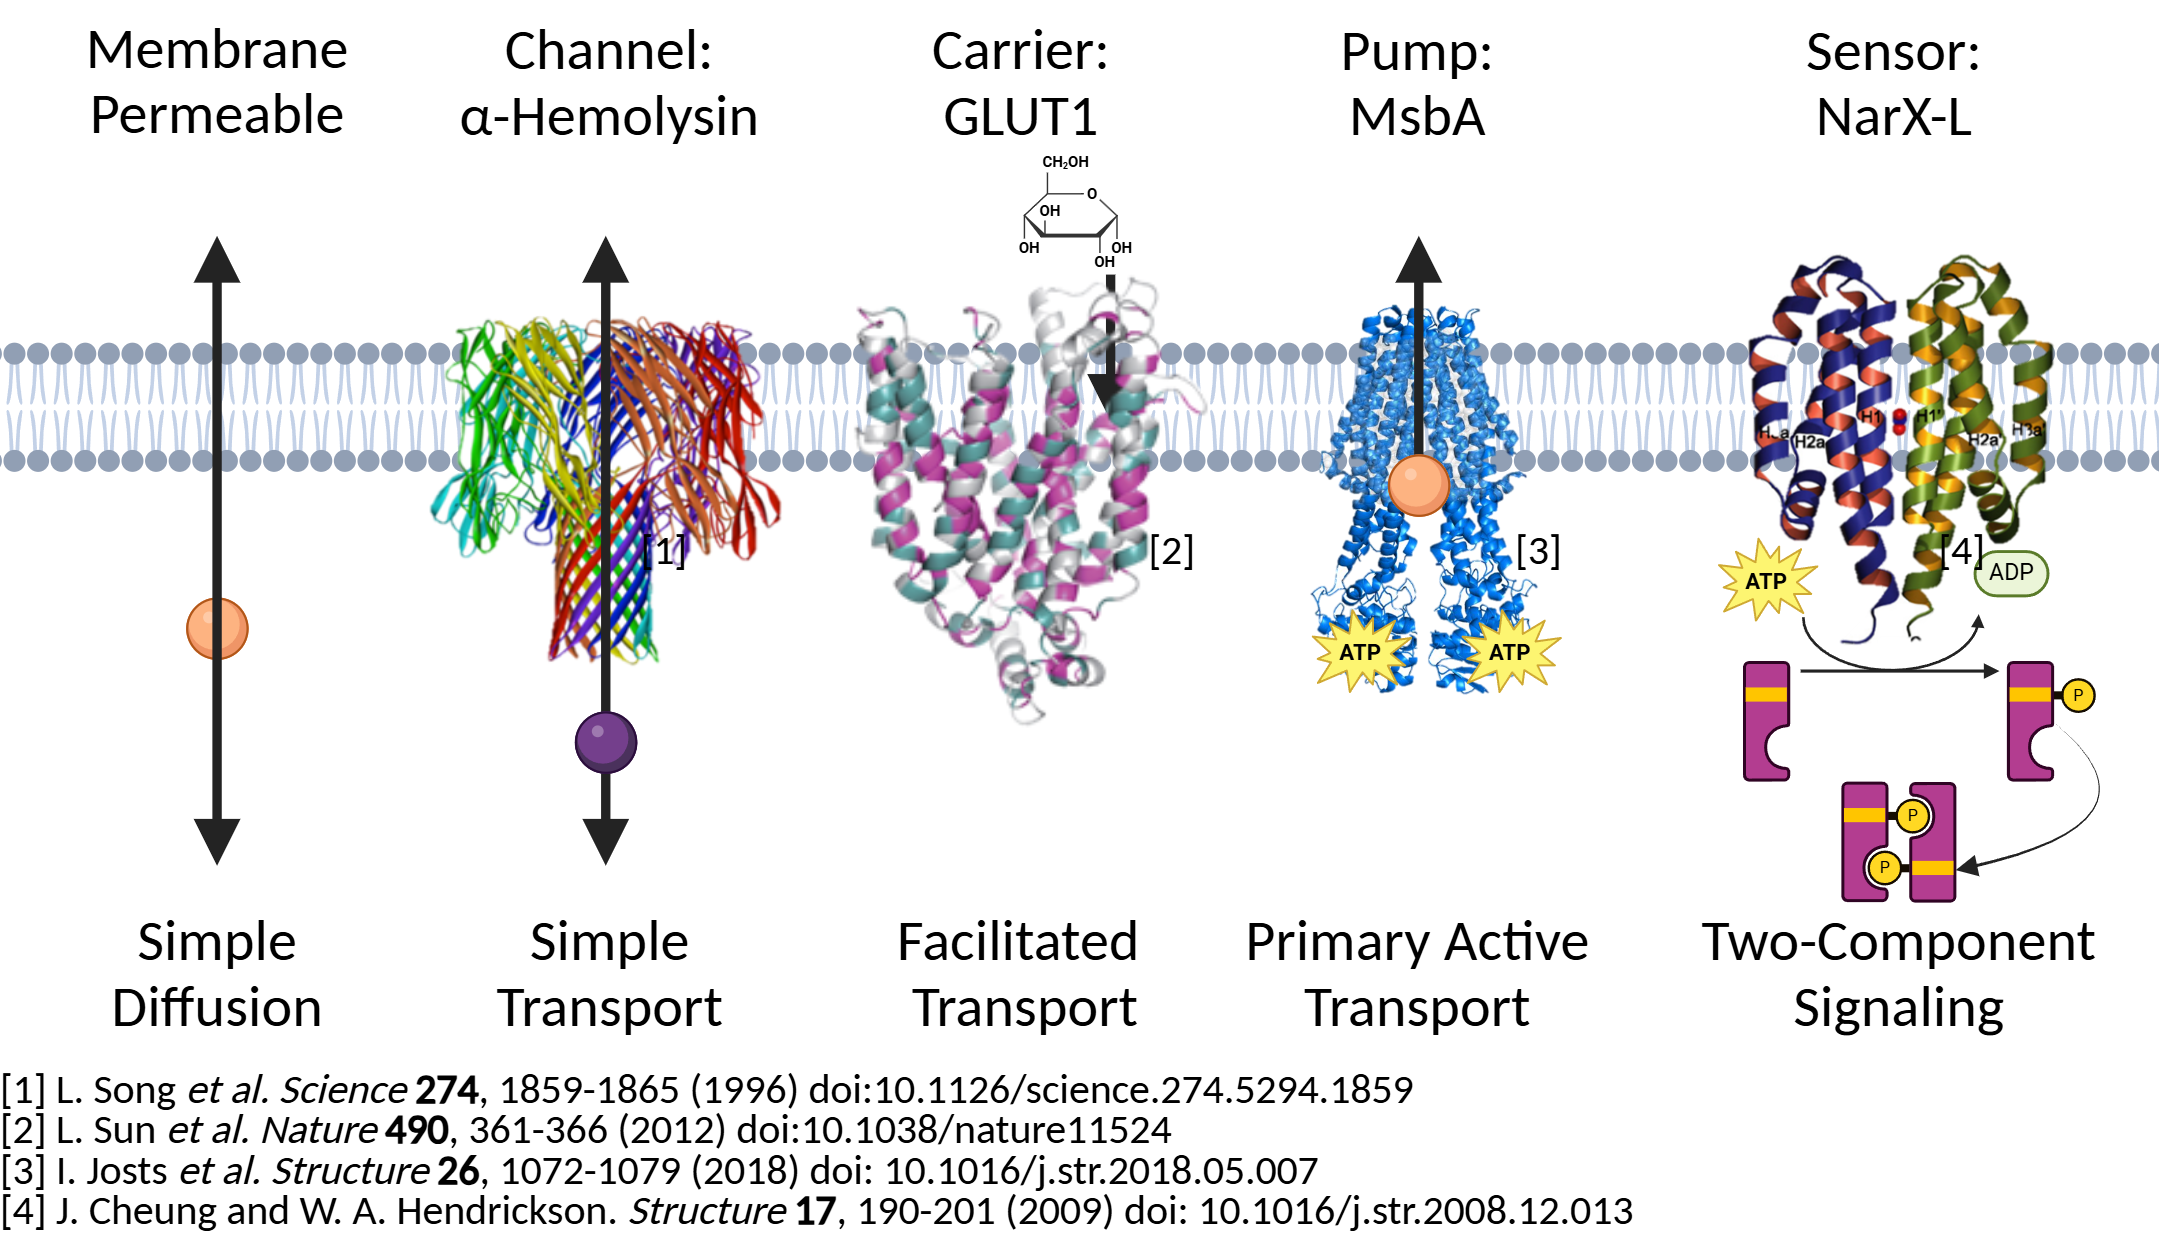
To create these models, we need to express the membrane protein. Next, we need to identify the membrane protein monomer, indicate the membrane transport mechanism, and its transport direction. If the protein functions as part of a two-component sensor (TCS), no transport activity will occur but the membrane sensor will auto-phosphorylate and subsequently phosphorylation the response protein.

### Packages

In [3]:
from biocrnpyler import *
# import bioscrape
import numpy as np
%matplotlib inline
import bokeh.io
import bokeh.plotting
bokeh.io.output_notebook()
from bokeh.themes import Theme
from bokeh.layouts import row

# Modules needed from Bokeh.
from bokeh.io import output_file, show
from bokeh.plotting import gridplot,figure
from bokeh.models import LinearAxis, Range1d
color=bokeh.palettes.Accent[6]
    
from bokeh.io import export_png

Loading BokehJS ...

In [2]:
# Function with some standard Bokeh plot settings
def create_custom_plot(title_text, x_max=8,y_max=2, yname=None):
    custom_plot = figure(
        toolbar_location='right',
        outline_line_color=None,
        min_border_right=10,
        height=400,
        width=400,
    )

    custom_plot.title.text = title_text
    custom_plot.xaxis.axis_label = 'Time (hours)'
    custom_plot.yaxis.axis_label = yname
    custom_plot.y_range = Range1d(0, y_max)
    custom_plot.x_range = Range1d(0, x_max)
    custom_plot.outline_line_color = None

    # custom_plot.yaxis
    custom_plot.ygrid.visible = False
    custom_plot.yaxis.axis_label_text_font_size = '15pt'
    custom_plot.yaxis.major_label_text_font_size = '15pt'
    custom_plot.yaxis.major_label_text_font = 'Work Sans'
    custom_plot.yaxis.axis_label_standoff = 15
    custom_plot.yaxis.axis_label_text_font_style = 'normal'

    # custom_plot.xaxis
    custom_plot.xgrid.visible = False
    custom_plot.xaxis.axis_label_text_font_size = '15pt'
    custom_plot.xaxis.major_label_text_font_size = '15pt'
    custom_plot.xaxis.major_label_text_font = 'Work Sans'
    custom_plot.xaxis.axis_label_standoff = 15
    custom_plot.xaxis.axis_label_text_font_style = 'normal'

    # custom_plot.title
    custom_plot.title.text_font_size = '18pt'
    custom_plot.title.align = 'left'
    custom_plot.title.offset = -50.0

    return custom_plot

# Example 0: Simple diffusion thorugh membrane (membrane permeable)
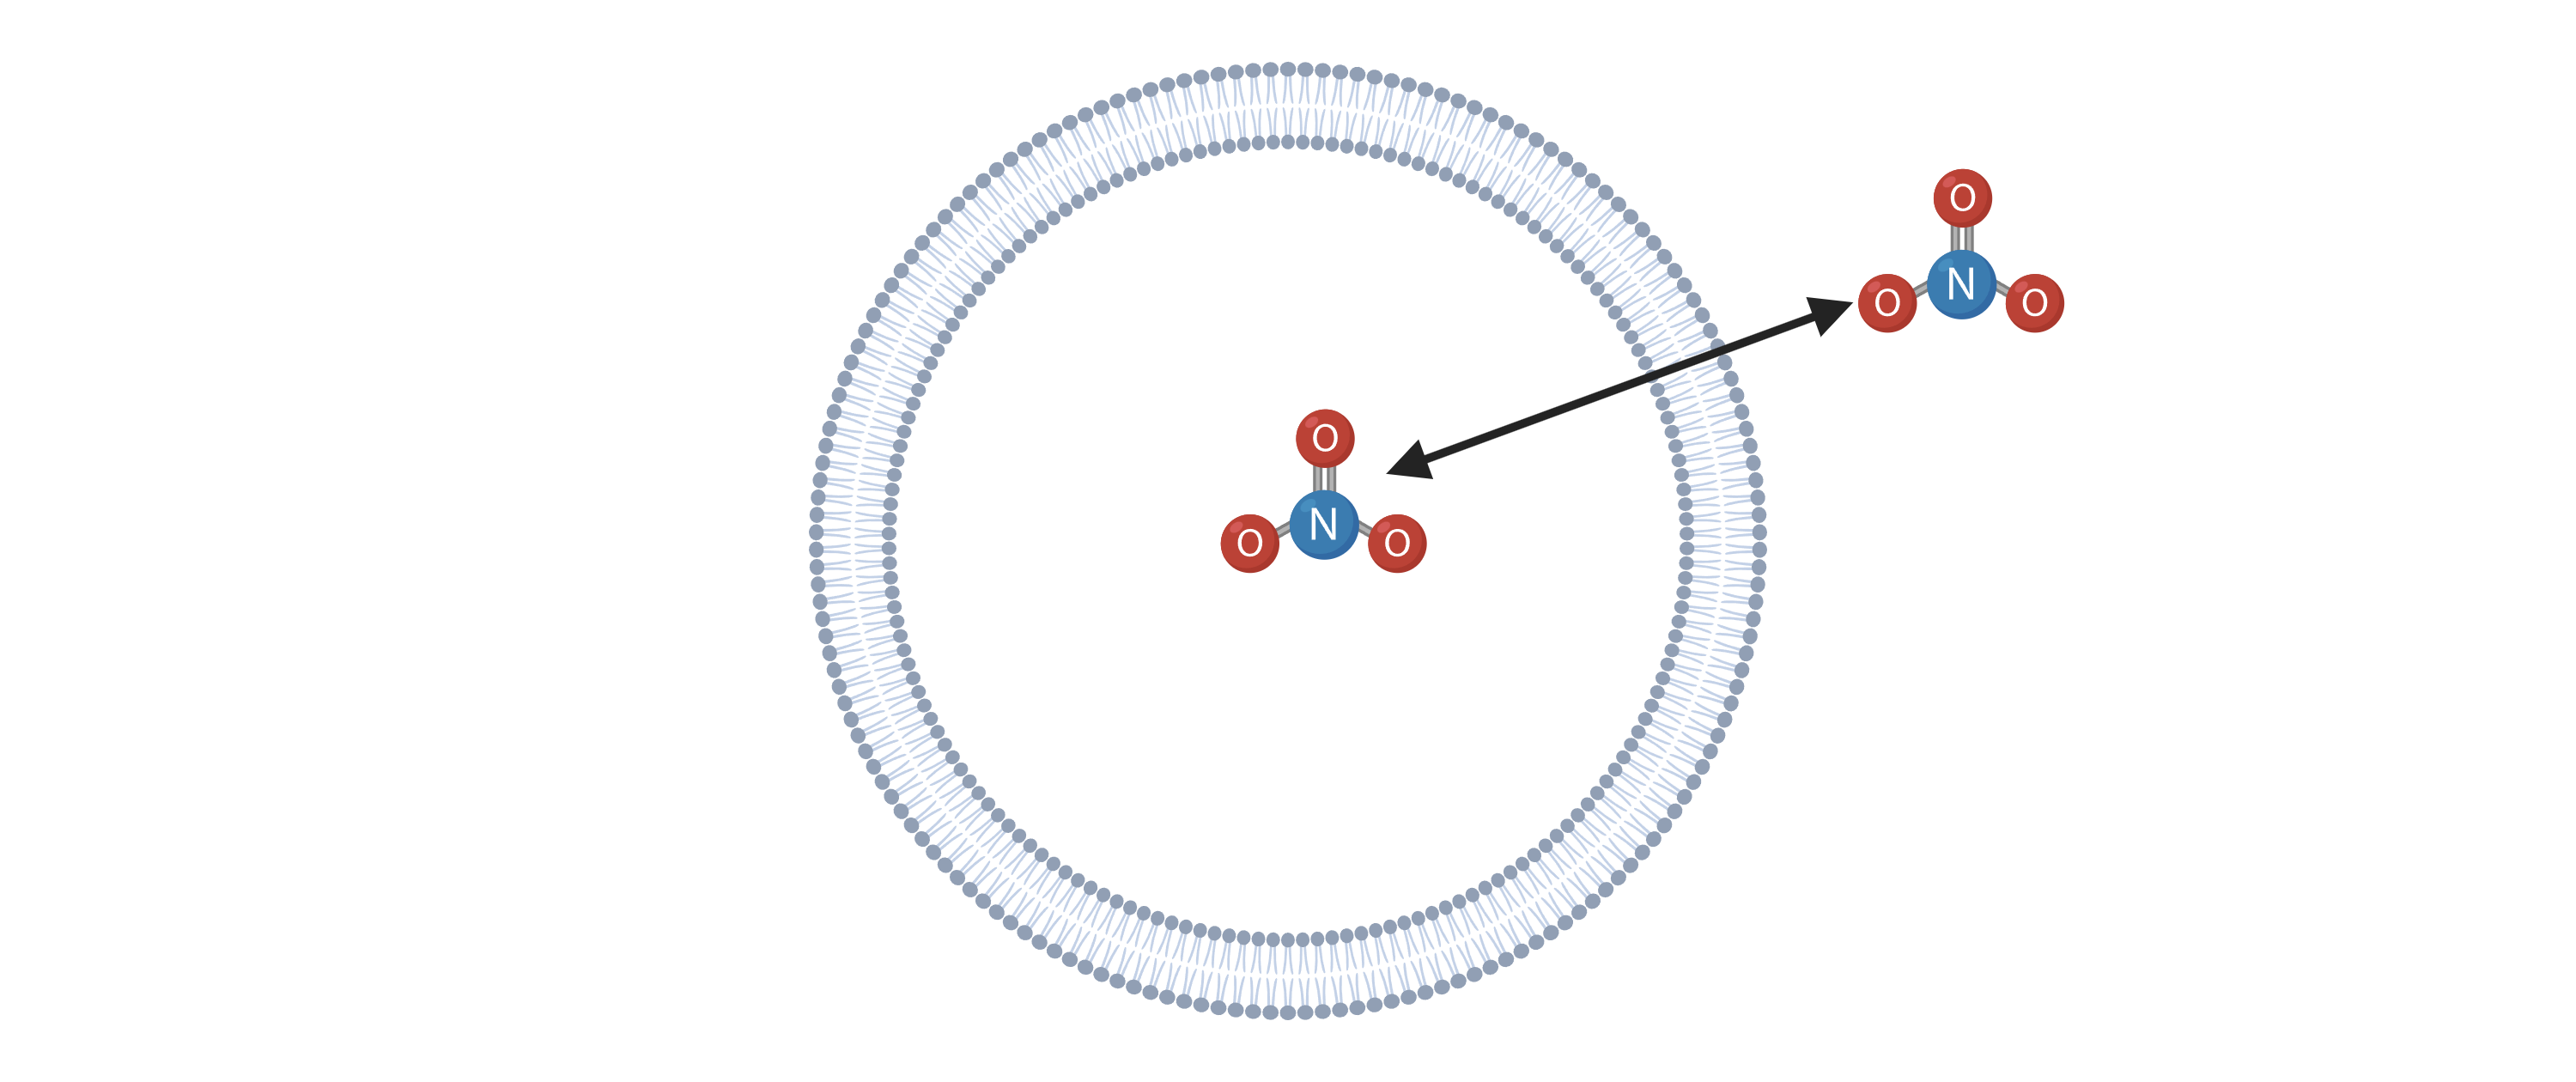
Consider the following diffusion step:
1. Diffusion of small molecules (i.e. Nitrate):
\begin{align}
    NO3_{internal} \rightleftharpoons NO3_{external}
\end{align}

## Define diffusible molecule

In [3]:
NO3=DiffusibleMolecule('NO3')

# default_parameters = {"k_diff":2e-4}
mech_cat = Simple_Diffusion() 

default_mechanisms = {mech_cat.mechanism_type:mech_cat}
M1= Mixture("Default Param Pathway", components = [NO3], parameter_file = "membrane_toolbox_parameters.txt",  mechanisms = default_mechanisms)
CRN0 = M1.compile_crn()

In [4]:
# Simulate CRN
try:
    import bioscrape
    import bokeh
except ModuleNotFoundError:
    print('please install the plotting libraries: pip install biocrnpyler[all]')
else:
    from biocrnpyler import *
    import numpy as np
    import pandas as pd
    maxtime = 300000
    timepoints = np.arange(0, maxtime, 100)
    #Inital conditions
    x0_dict= {'NO3_Internal':2}
    
    #Run Simulation
    R = CRN0.simulate_with_bioscrape_via_sbml(timepoints = timepoints, initial_condition_dict = x0_dict)

    #Plot NO3 diffusion
    p2 =create_custom_plot("NO3 Diffusion", x_max=8,y_max= 2, yname='NO3 (uM)')
    p2.line(timepoints/3600,  R['NO3_Internal'], line_width = 3, color=color[0], legend_label='Internal')
    p2.line(timepoints/3600,  R['NO3_External'], line_width = 3, color=color[2],legend_label='External',line_dash = 'dashed')
    
    # Display the layout
    show(p2)

## Example 1: Integration of membrane protein (monomer) and simple transport by a membrane channel (ex. IPTG and $\alpha$-hemolysin)
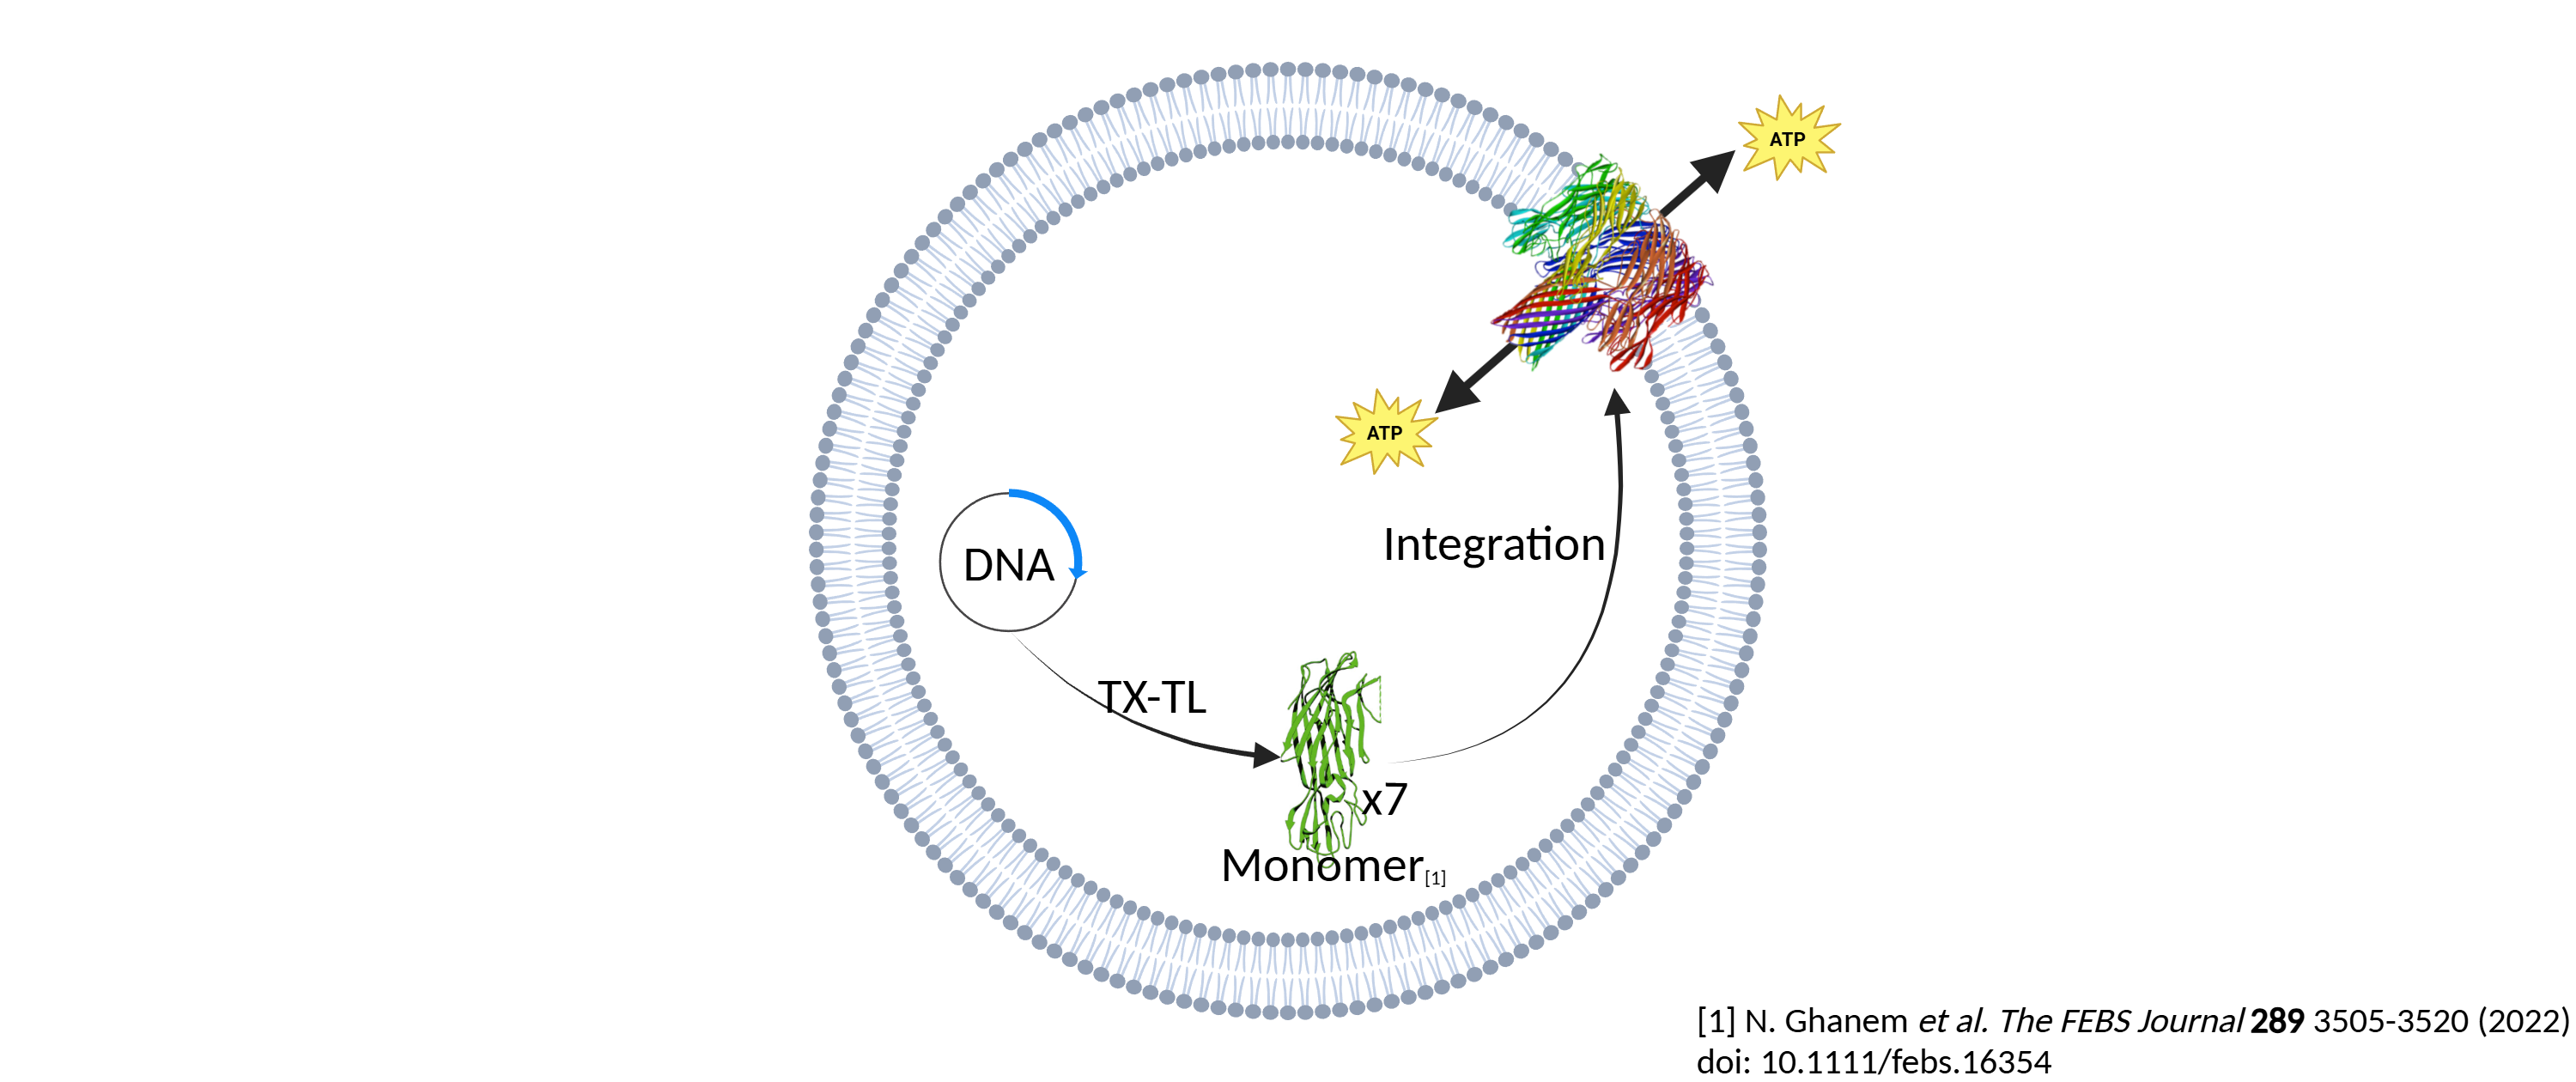
Consider the following substrate transport steps:
1. Expression of $\alpha$HL protein (monomer):
\begin{align}
    DNA_{\alpha HL} + TXTL_{Energy} \rightarrow \alpha HL_{monomer}
\end{align}
2. Assemble into a homoheptamer:
\begin{align}
    7\alpha HL_{monomer} \rightarrow \alpha HL_{homoheptamer}
\end{align}
3. Integration of membrane protein in membrane:
\begin{align}
    \alpha HL_{homoheptamer} \rightarrow \alpha HL_{channel}
\end{align}
6. Diffusion of small molecules (i.e. ATP) across membrane:
\begin{align}
    ATP_{internal} +\alpha HL_{channel} \rightleftharpoons ATP_{external}+\alpha HL_{channel}
\end{align}

## Identify the membrane protein monomer

In [5]:
alphaHL_monomer = IntegralMembraneProtein('alphaHL_monomer', product='alphaHL', size=7)

# default_parameters = {"kb1":2e-3, "ku1": 2e-10 ,"kcat":10, "kex":.5,"kb2":5 }
mech_cat = Membrane_Protein_Integration() 

default_mechanisms = {mech_cat.mechanism_type:mech_cat}

M1= Mixture("Default Param Pathway", components = [alphaHL_monomer], parameter_file = "membrane_toolbox_parameters.txt",  mechanisms = default_mechanisms)
# print("repr(Mixture) gives a printout of what is in a mixture and what it's Mechanisms are:\n", repr(M1),"\n")

#Compile the CRN with Mixture.compile_crn
CRN1 = M1.compile_crn()
# print(CRN1.pretty_print(show_rates = True, show_attributes = True, show_materials = True, show_keys = False))

## Define membrane channel and transport mechanism
Internal and external fractions of the substrate are created

In [6]:
alphaHL_channel=MembraneChannel(alphaHL_monomer.product, substrate='ATP')

# default_parameters = {"k_trnsp":1e-1}

mech_cat = Simple_Transport()

default_mechanisms = {mech_cat.mechanism_type:mech_cat}

M2 = Mixture("Default Param Pathway", components = [alphaHL_channel], parameter_file = "membrane_toolbox_parameters.txt",  mechanisms = default_mechanisms)
# print("repr(Mixture) gives a printout of what is in a mixture and what it's Mechanisms are:\n", repr(M2),"\n")

#Compile the CRN with Mixture.compile_crn
CRN2 = M2.compile_crn()
# print(CRN2.pretty_print(show_rates = True, show_attributes = True, show_materials = True, show_keys = False))

## Activatable expression of $\alpha$-HL protein (monomer)

In [7]:
#ActivatedPromoter
activator = Species("T7RNAP", material_type = "small_molecule")

#Create a custom set of parameters
hill_parameters = {"k":1.0, "n":4, "K":20, "kleak":0.0001}
P_activatable = ActivatablePromoter("P_activtable", activator = activator, leak = False, parameters = hill_parameters)

#Create a DNA assembly "reporter" with P_activatable for its promoter
activatable_assembly = DNAassembly("activatable_assembly", promoter = P_activatable, rbs = "rbs", initial_concentration = 1*10**-3, protein= alphaHL_monomer.membrane_protein)

E = EnergyTxTlExtract( components=[activatable_assembly], parameter_file = "txtl_toolbox_parameters.txt")

CRN = E.compile_crn()
# print(CRN.pretty_print())

C:\Users\zoila\anaconda3\envs\modeling_compartments\Lib\site-packages\biocrnpyler\parameter.py:507: UserWarning: parameter file contains no unit column! Please add a column named ['unit', 'units'].
  warn(f"parameter file contains no {accepted_name} column! Please add a "


## Combine all mixtures

In [8]:
addReactions=CRN1.reactions + CRN2.reactions
addSpecies=CRN1.species + CRN2.species

CRN.add_species(addSpecies)
CRN.add_reactions(addReactions)

In [9]:
# Simulate CRN
try:
    import bioscrape
    import bokeh
except ModuleNotFoundError:
    print('please install the plotting libraries: pip install biocrnpyler[all]')
else:
    from biocrnpyler import *
    import numpy as np
    import pandas as pd
    maxtime = 300000
    timepoints = np.arange(0, maxtime, 100)
    
    #Inital conditions
    x0_dict= {'small_molecule_T7RNAP':1.2,alphaHL_channel.product:5,}

    #Run Simulation
    R = CRN.simulate_with_bioscrape_via_sbml(timepoints = timepoints, initial_condition_dict = x0_dict)

    #Plot alpha-hemolysin protien and the multiple configurations
    p2 =create_custom_plot("alpha-hemolysin Expression", x_max=8,y_max= .014, yname='monomer (uM)')
    p2.line(timepoints/3600,  R['protein_alphaHL_monomer_Internal'], line_width = 3, line_alpha=.5, color=color[1], legend_label='monomer')
    p2.line(timepoints/3600,  R['complex_protein_alphaHL_monomer_Internal_7x_'], line_width = 3, line_alpha=.5, color=color[4], legend_label='polymer')
    p2.line(timepoints/3600,  R['protein_alphaHL_Passive_Membrane'], line_width = 3, line_alpha=.5, color=color[5], legend_label='channel')
    
    #Plot the transport of substrate ATP
    p3 =create_custom_plot("Passive Transport of ATP", x_max=18,y_max= 5, yname='ATP (uM)')
    p3.line(timepoints/3600,  R['ATP_Internal'], line_width = 3, legend_label = "Internal", color=color[0])
    p3.line(timepoints/3600,  R['ATP_External'], line_width = 3, legend_label = "External", color=color[2], line_dash = 'dashed')
    
    # Arrange the plots in a row layout
    layout = row(p2, p3)
    # Display the layout
    show(layout) # Display the layout

# Example 2: Integration of membrane protein (homdimer) and facilitated transport by a membrane carrier (ex. glucose and GLUT1)
GLUT1: A Facilitated Passive Diffusion Protein modeled as a monomer (though can form dimers and tetrameter)
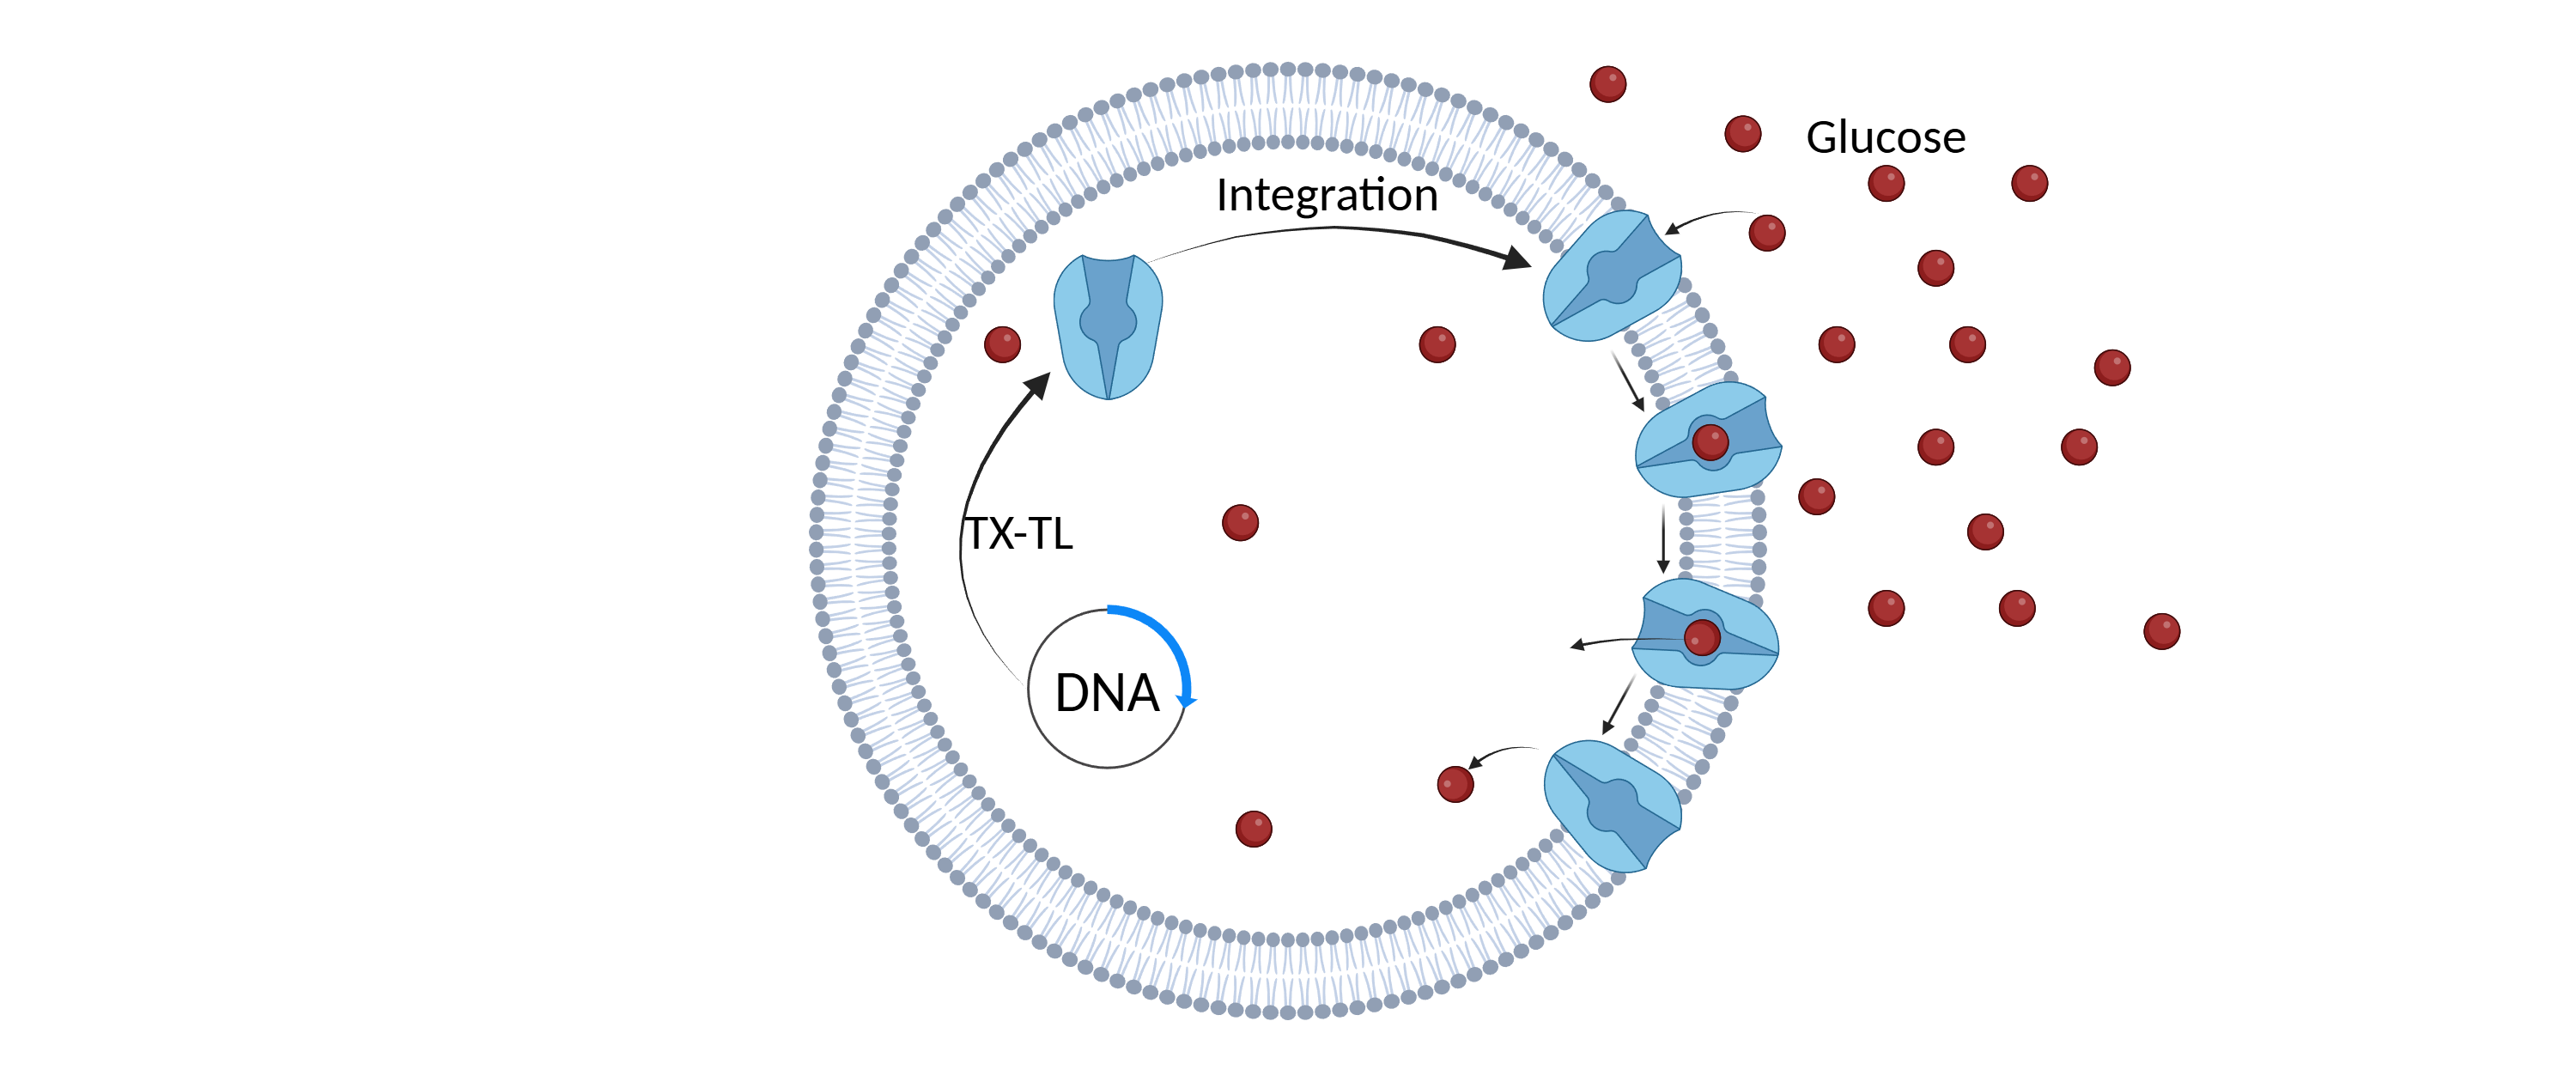
Consider the following substrate transport steps:
1. Expression of GLUT1 protein (monomer):
\begin{align}
    DNA_{GLUT1} + TXTL_{Energy} \rightarrow GLUT1_{monomer}
\end{align}
2. Integration of membrane protein in membrane:
\begin{align}
    GLUT1_{monomer} \rightarrow GLUT1_{channel}
\end{align}
3. Binding and transport of glucose across membrane:
\begin{align}
    glucose_{external} + GLUT1_{channel} \rightarrow glucose_{external}:GLUT1_{channel} \rightarrow glucose_{internal}:GLUT1_{channel}
\end{align}
4. Unbinding glucose from transporter:
\begin{align}
    glucose_{internal}:GLUT1_{channel} \rightarrow glucose_{internal} + GLUT1_{channel}
\end{align}

## Identify the membrane protein monomer

In [12]:
glut1 = IntegralMembraneProtein('glut1', product='glut1_channel', direction='Importer', size= 1)

# default_parameters = {"kd1":5,"kb1":2e-3, "ku1": 2e-10 ,"kcat":10, "kex":.5,"kd2":5 }
mech_cat = Membrane_Protein_Integration()

default_mechanisms = {mech_cat.mechanism_type:mech_cat}

M1= Mixture("Default Param Pathway", components = [glut1], parameter_file = "membrane_toolbox_parameters.txt",  mechanisms = default_mechanisms)
print("repr(Mixture) gives a printout of what is in a mixture and what it's Mechanisms are:\n", repr(M1),"\n")

#Compile the CRN with Mixture.compile_crn
CRN1 = M1.compile_crn()
# print(CRN1.pretty_print(show_rates = True, show_attributes = True, show_materials = True, show_keys = False))

repr(Mixture) gives a printout of what is in a mixture and what it's Mechanisms are:
 Mixture: Default Param Pathway
Components = [
	IntegralMembraneProtein: glut1 ]
Mechanisms = {
	membrane_insertion:membrane_protein_integration } 



## Define membrane channel and transport mechanism
Internal and external fractions of the substrate are created

In [13]:
glut1_channel=MembraneChannel(glut1.product, substrate='glucose')

# default_parameters = {"k_trnsp":1e-2, "ku1":1e-1,"ku2":1e-1, "k1":1e-1}

mech_cat = Facilitated_Transport_MM()

default_mechanisms = {mech_cat.mechanism_type:mech_cat}

M2 = Mixture("Default Param Pathway", components = [glut1_channel], parameter_file = "membrane_toolbox_parameters.txt",  mechanisms = default_mechanisms)
print("repr(Mixture) gives a printout of what is in a mixture and what it's Mechanisms are:\n", repr(M2),"\n")

# #Compile the CRN with Mixture.compile_crn
CRN2 = M2.compile_crn()
# # print(CRN2.pretty_print(show_rates = True, show_attributes = True, show_materials = True, show_keys = False))

repr(Mixture) gives a printout of what is in a mixture and what it's Mechanisms are:
 Mixture: Default Param Pathway
Components = [
	MembraneChannel: glut1_channel ]
Mechanisms = {
	transport:facilitated_membrane_protein_transport } 



## Activatable expression of GLUT1 protein (monomer)

In [14]:
#ActivatedPromoter
activator = Species("T7RNAP", material_type = "small_molecule")

#Create a custom set of parameters
hill_parameters = {"k":1.0, "n":4, "K":20, "kleak":0.0001}
P_activatable = ActivatablePromoter("P_activtable", activator = activator, leak = False, parameters = hill_parameters)

#Create a DNA assembly "reporter" with P_activatable for its promoter
activatable_assembly = DNAassembly("activatable_assembly", promoter = P_activatable, rbs = "rbs", initial_concentration = 1*10**-3, protein= glut1.membrane_protein)

E = EnergyTxTlExtract( components=[activatable_assembly], parameter_file = "txtl_toolbox_parameters.txt")

CRN = E.compile_crn()
# print(CRN.pretty_print())

C:\Users\zoila\anaconda3\envs\modeling_compartments\Lib\site-packages\biocrnpyler\parameter.py:507: UserWarning: parameter file contains no unit column! Please add a column named ['unit', 'units'].
  warn(f"parameter file contains no {accepted_name} column! Please add a "


## Combine all mixtures

In [15]:
addReactions=CRN1.reactions + CRN2.reactions
addSpecies=CRN1.species + CRN2.species

CRN.add_species(addSpecies)
CRN.add_reactions(addReactions)

In [16]:
# Simulate CRN
try:
    import bioscrape
    import bokeh
except ModuleNotFoundError:
    print('please install the plotting libraries: pip install biocrnpyler[all]')
else:
    from biocrnpyler import *
    import numpy as np
    import pandas as pd
    maxtime = 300000
    timepoints = np.arange(0, maxtime, 100)

    #Inital conditions
    # x0_dict= {'small_molecule_T7RNAP':1.2,'glucose_External':0,'glucose_Internal':5}
    # x0_dict= {'small_molecule_T7RNAP':1.2,'glucose_External':8,'glucose_Internal':5}
    x0_dict= {'small_molecule_T7RNAP':1.2,'glucose_External':5,'glucose_Internal':0}

    #Run Simulation
    R = CRN.simulate_with_bioscrape_via_sbml(timepoints = timepoints, initial_condition_dict = x0_dict)

    #Plot GLUT1 protein and the multiple configurations
    p2 =create_custom_plot("glut1 Expression", x_max=8,y_max= .1, yname='monomer (uM)')
    p2.line(timepoints/3600,  R['protein_glut1_Internal'], line_width = 3, line_alpha=.5, color=color[1], legend_label='monomer')
    p2.line(timepoints/3600,  R['protein_glut1_channel_Importer_Membrane'], line_width = 3, line_alpha=.5,color=color[4],legend_label='channel')
    
    #Plot the transport of substrate Glucose
    p3 =create_custom_plot("Facilitated Transport of Glucose", x_max=18,y_max= 5, yname='Glucose (uM)')
    p3.line(timepoints/3600,  R['glucose_Internal'], line_width = 3, legend_label = "Internal", color=color[0])
    p3.line(timepoints/3600,  R['glucose_External'], line_width = 3, legend_label = "External", color=color[2], line_dash = 'dashed')
    
    # Arrange the plots in a row layout
    layout = row(p2, p3)
    # Display the layout
    show(layout) # Display the layout

# Example 3: Integration of membrane protein (homodimer) and active transport by a membrane pump (ex. antibiotic and MsbA)
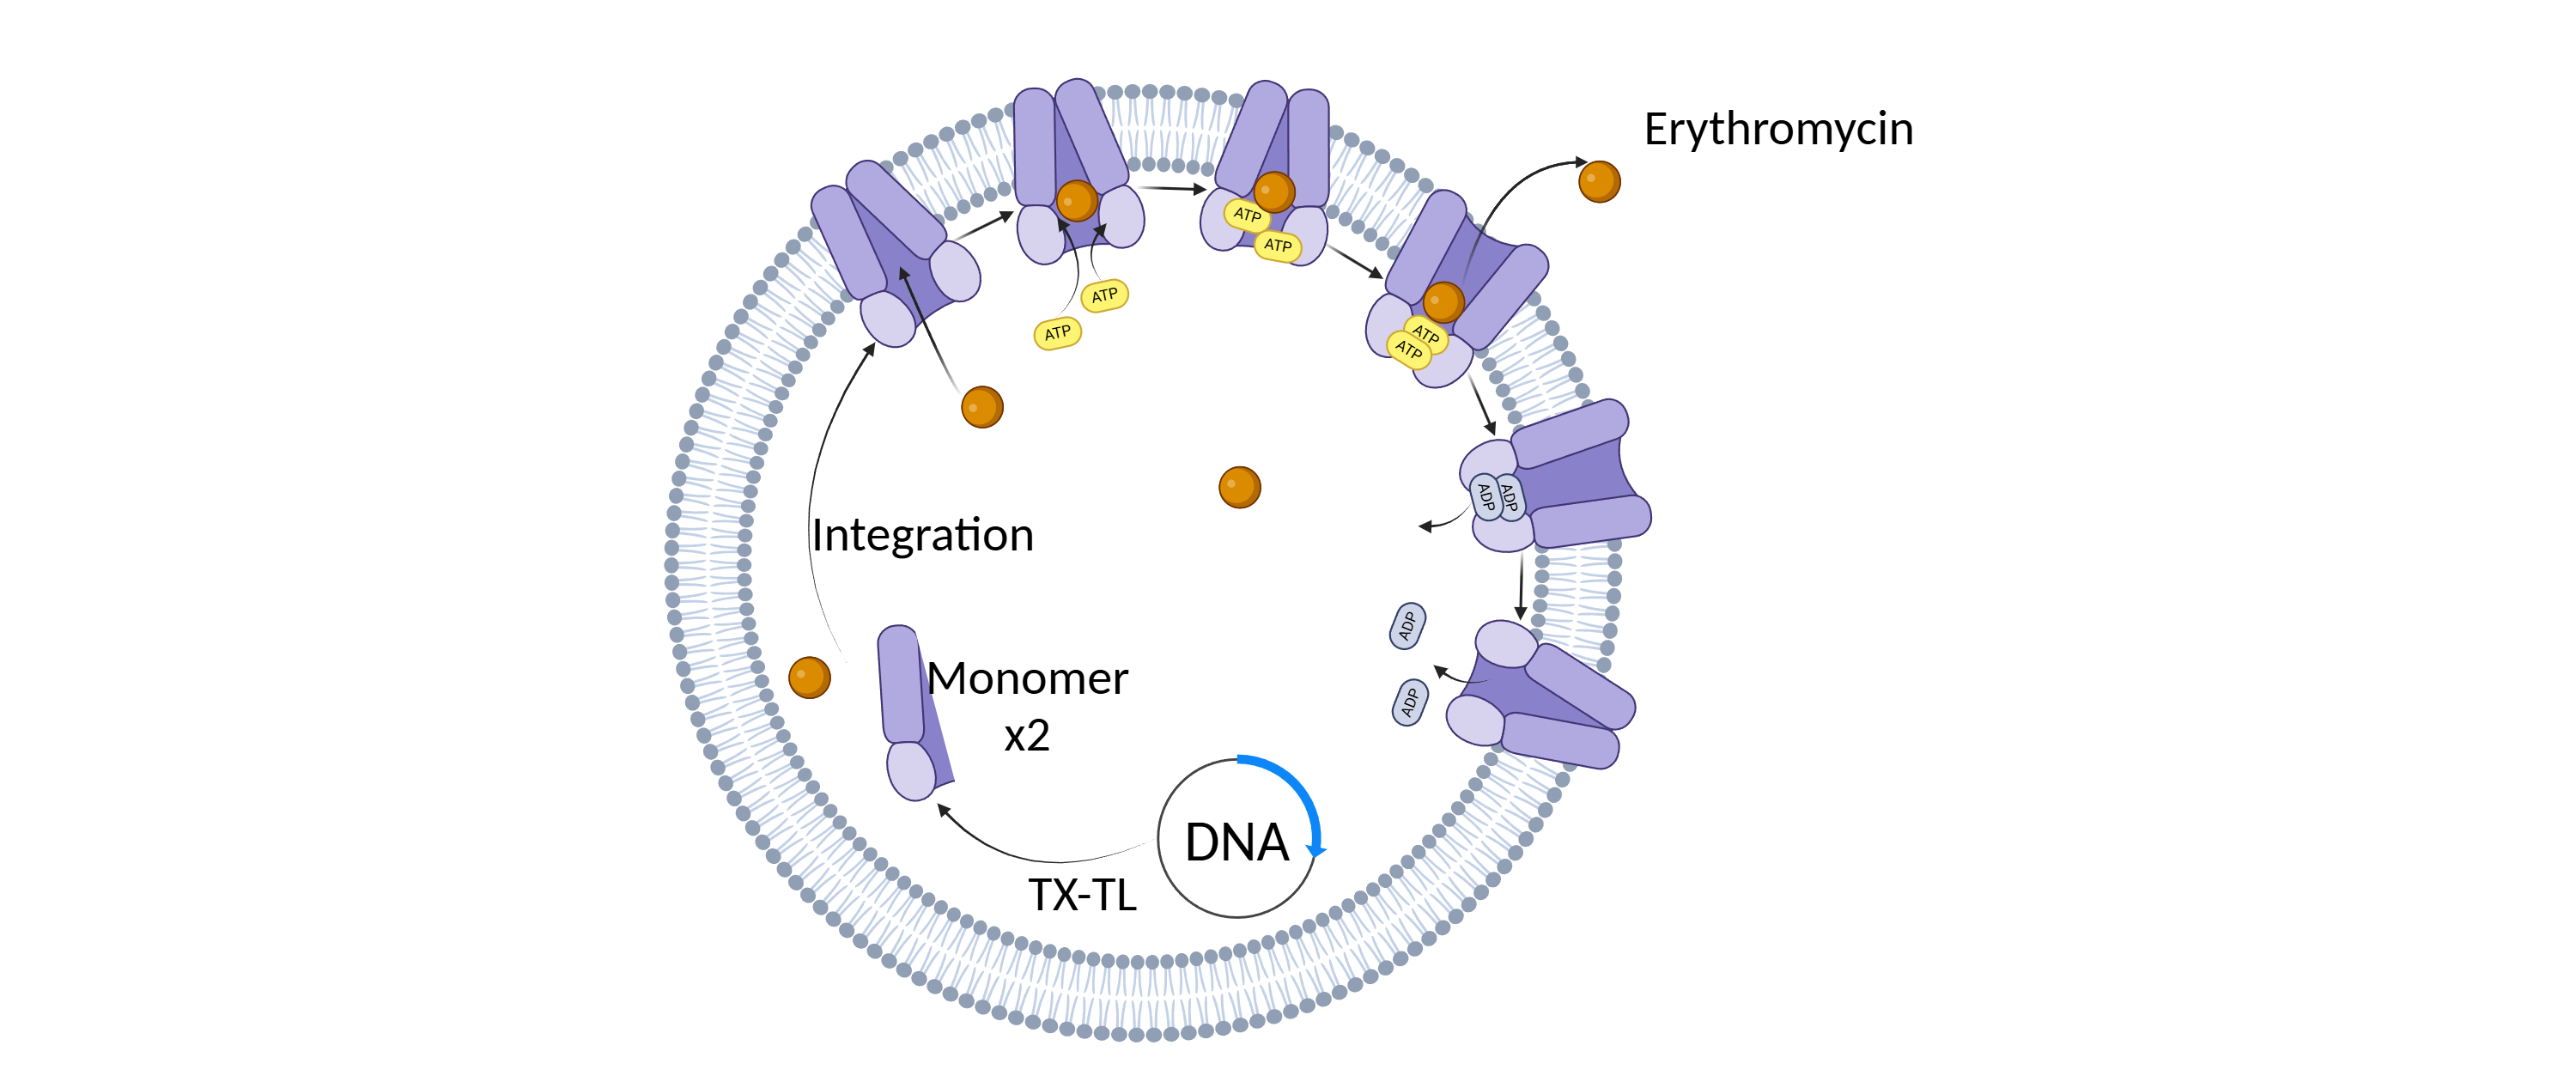
Consider the following substrate transport steps:
1. Expression of MsbA protein (monomer):
\begin{align}
    DNA_{MsbA} + TXTL_{Energy} \rightarrow MsbA_{monomer}
\end{align}
2. Assemble into a homodimer:
\begin{align}
    2MsbA_{monomer} \rightarrow MsbA_{homodimer}
\end{align}
3. Integration of membrane protein in membrane:
\begin{align}
    MsbA_{homodimer} \rightarrow MsbA_{exporter}
\end{align}
4. Binding of antibiotic (Abx) substrate (i.e. erythromycin) to MsbA transporter:
\begin{align}
    Abx_{internal}+ MsbA_{exporter} \rightleftharpoons Abx_{internal}:MsbA_{exporter}
\end{align}
5. Binding of ATP to complex of erythromycin with MsbA:
    \begin{align}
        2ATP_{internal} + Abx_{internal}:MsbA_{exporter} \rightleftharpoons 2ATP_{internal}:Abx_{internal}: MsbA_{exporter}
    \end{align}
6. Export of erythromycin lipid from inner membrane to outer membrane:
    \begin{align}
        2ATP_{internal}:Abx_{internal}:MsbA_{exporter} \rightarrow 2ATP_{internal}:Abx_{external}:MsbA_{transporter}
    \end{align}
7. Unbinding of erythromycin:
    \begin{align}
        2ATP_{internal}:Abx_{external}:MsbA_{exporter} \rightarrow 2ADP_{internal}:MsbA_{exporter} + Abx_{external}
    \end{align}
8. Unbinding of ADP with MsbA:
    \begin{align}
        2ADP_{internal}:MsbA_{exporter} \rightarrow 2ADP_{internal}:MsbA_{exporter}
    \end{align}

## Identify the membrane protein monomer

In [19]:
MsbA_monomer = IntegralMembraneProtein('MsbA_monomer', product='MsbA_pump', size=2, direction='Exporter')

# default_parameters = {"kb1":2e-3, "ku1": 2e-10 ,"kcat":10, "kex":.5,"kb2":5 }
mech_cat = Membrane_Protein_Integration() #cant be 0

default_mechanisms = {mech_cat.mechanism_type:mech_cat}

M1= Mixture("Default Param Pathway", components = [MsbA_monomer], parameter_file = "membrane_toolbox_parameters.txt",  mechanisms = default_mechanisms)
# print("repr(Mixture) gives a printout of what is in a mixture and what it's Mechanisms are:\n", repr(M1),"\n")

#Compile the CRN with Mixture.compile_crn
CRN1 = M1.compile_crn()
print(CRN1.pretty_print(show_rates = True, show_attributes = True, show_materials = True, show_keys = False)) 

Species(N = 3) = {
complex[2x_protein[MsbA_monomer]] (@ 0),  protein[MsbA_pump(Exporter)] (@ 0),  protein[MsbA_monomer] (@ 0),  
}

Reactions (2) = [
0. 2protein[MsbA_monomer] <--> complex[2x_protein[MsbA_monomer]]
 Kf=k_forward * protein_MsbA_monomer_Internal^2
 Kr=k_reverse * complex_protein_MsbA_monomer_Internal_2x_
  k_forward=0.002
  k_reverse=2e-10

1. complex[2x_protein[MsbA_monomer]] --> protein[MsbA_pump(Exporter)]
 Kf = k complex[2x_protein[MsbA_monomer]] / ( 1 + (protein[MsbA_pump(Exporter)]/K)^4 )
  k=0.5
  K=10
  n=4

]


## Define membrane channel and transport mechanism
Internal and external fractions of the substrate are created

In [20]:
MsbA_pump=MembranePump(MsbA_monomer.product, substrate='Abx', ATP=2)

# default_parameters = {"k1":1e-1, "ku1":0.1, "k2":1e-1, "ku2":1e-2,
#                       "k_trnsp":1e-2,"ku3":.1,"ku4":.1,}
#                       # "kb3":.1,"kb4":.1, "kcat":10., "kb1":100, "ku6":.1,"ku5":.1,
                     
#                       # "kex":.3,"kcat_rev":0.1, 

mech_cat = Primary_Active_Transport_MM()

default_mechanisms = {mech_cat.mechanism_type:mech_cat}

M2= Mixture("Default Param Pathway", components = [MsbA_pump], parameter_file = "membrane_toolbox_parameters.txt",  mechanisms = default_mechanisms)
# print("repr(Mixture) gives a printout of what is in a mixture and what it's Mechanisms are:\n", repr(M2),"\n")

#Compile the CRN with Mixture.compile_crn
CRN2 = M2.compile_crn()
# print(CRN2.pretty_print(show_rates = True, show_attributes = True, show_materials = True, show_keys = False))

## Activatable expression of MsbA protein (monomer)

In [21]:
#ActivatedPromoter
activator = Species("T7RNAP", material_type = "small_molecule")

#Create a custom set of parameters
hill_parameters = {"k":1.0, "n":4, "K":20, "kleak":0.0001}
P_activatable = ActivatablePromoter("P_activtable", activator = activator, leak = False, parameters = hill_parameters)

#Create a DNA assembly "reporter" with P_activatable for its promoter
activatable_assembly = DNAassembly("activatable_assembly", promoter = P_activatable, rbs = "rbs", initial_concentration = 1*10**-3, protein= MsbA_monomer.membrane_protein)

E = EnergyTxTlExtract( components=[activatable_assembly], parameter_file = "txtl_toolbox_parameters.txt")

CRN = E.compile_crn()
# print(CRN.pretty_print())

C:\Users\zoila\anaconda3\envs\modeling_compartments\Lib\site-packages\biocrnpyler\parameter.py:507: UserWarning: parameter file contains no unit column! Please add a column named ['unit', 'units'].
  warn(f"parameter file contains no {accepted_name} column! Please add a "


## Combine all mixtures

In [22]:
addReactions=CRN1.reactions + CRN2.reactions
addSpecies=CRN1.species + CRN2.species

CRN.add_species(addSpecies)
CRN.add_reactions(addReactions)

In [23]:
# Simulate CRN
try:
    import bioscrape
    import bokeh
except ModuleNotFoundError:
    print('please install the plotting libraries: pip install biocrnpyler[all]')
else:
    from biocrnpyler import *
    import numpy as np
    import pandas as pd
    maxtime = 300000
    timepoints = np.arange(0, maxtime, 100)

    #Inital conditions
    x0_dict= {'small_molecule_T7RNAP':1.2, 'Abx_Internal':1,'Abx_External':1,'small_molecule_ATP_Internal':100}

    #Run Simulation
    R = CRN.simulate_with_bioscrape_via_sbml(timepoints = timepoints, initial_condition_dict = x0_dict)

    #Plot MsbA protien and the multiple configurations
    p2 =create_custom_plot("MsbA Expression", x_max=20,y_max= .04, yname='Protein (uM)')
    p2.line(timepoints/3600,  R['protein_MsbA_monomer_Internal'], line_width = 3, line_alpha=.5, color=color[1], legend_label='monomer')
    p2.line(timepoints/3600,  R['complex_protein_MsbA_monomer_Internal_2x_'], line_width = 3, line_alpha=.5,color=color[4], legend_label='dimer')
    p2.line(timepoints/3600,  R['protein_MsbA_pump_Exporter_Membrane'], line_width = 3, line_alpha=.5,color=color[5], legend_label='channel')
    
    #Plot the transport of substrate Abx
    p3 =create_custom_plot("Active Transport of Abx", x_max=18,y_max= 2.1, yname='Abx (uM)')
    p3.line(timepoints/3600,  R['Abx_Internal'], line_width = 3, legend_label = "Internal", color=color[0])
    p3.line(timepoints/3600,  R['Abx_External'], line_width = 3, legend_label = "External",color=color[2],line_dash = 'dashed')
    
    # Arrange the plots in a row layout
    layout = row(p2, p3)
    # Display the layout
    show(layout) # Display the layout


# Example 4: Integration of membrane protein (homodimer) and two-component regulatory system (NarX-L). 
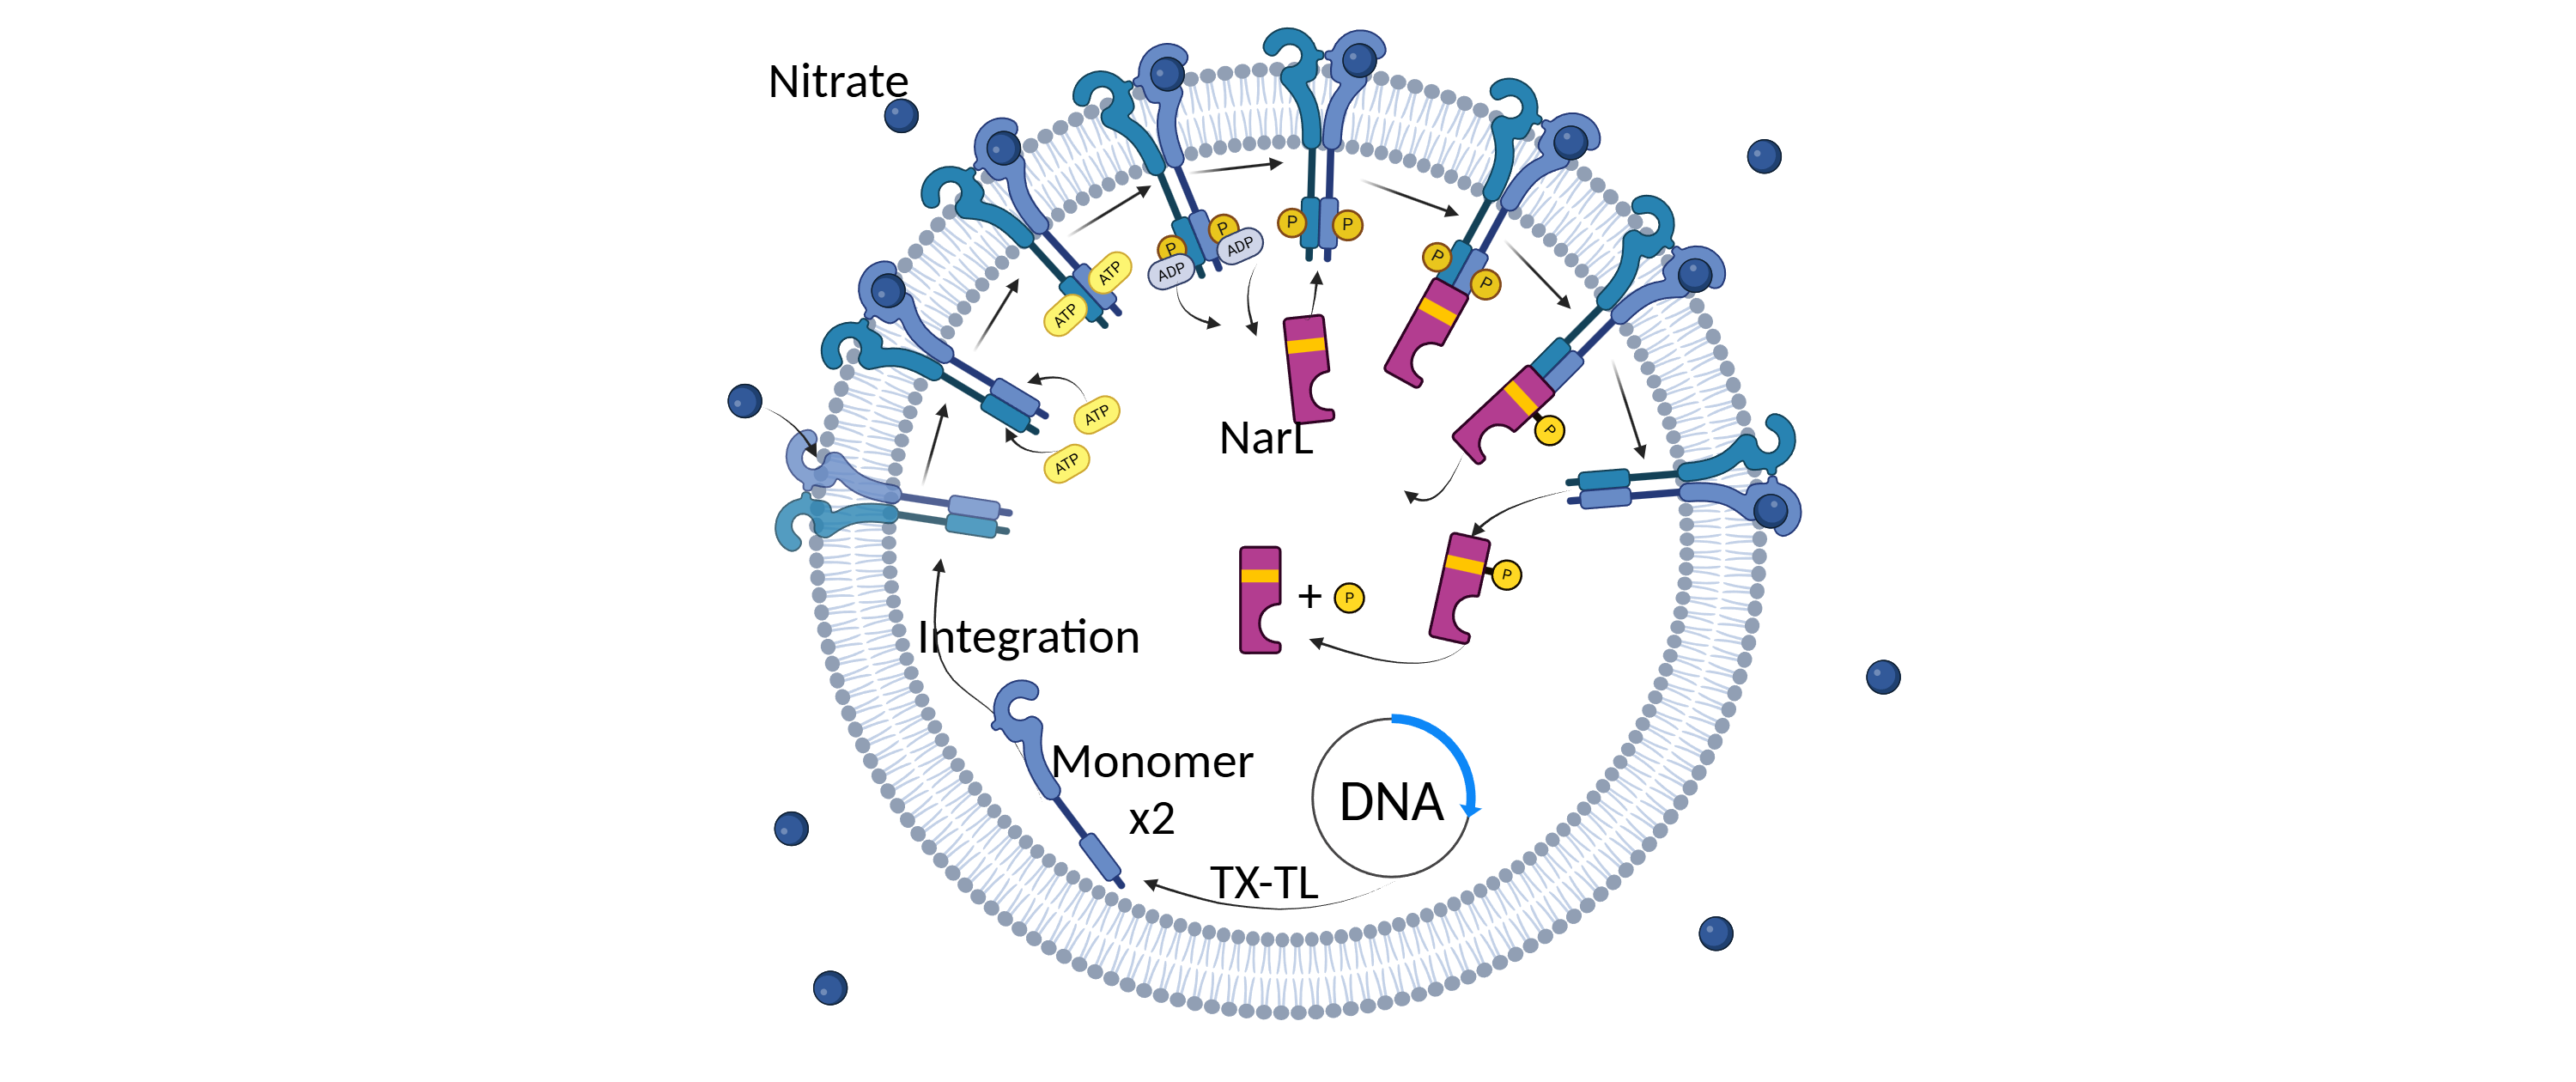
Consider the following signal transduction pathways:
1. Expression of NarX protein (monomer):
\begin{align}
    DNA_{NarX} + TXTL_{Energy} \rightarrow NarX_{monomer}
\end{align}
2. Assemble into a homodimer:
\begin{align}
    2NarX_{monomer} \rightarrow NarX_{homodimer}
\end{align}
3. Integration of membrane protein in membrane:
\begin{align}
    NarX_{homodimer} \rightarrow NarX_{sensor}
\end{align}
4. Detecting and binding to nitrate (NO3):
\begin{align}
    NarX_{sensor} +  NO_3 \rightleftharpoons NarX_{sensor}:NO_3 \equiv NarX^*_{sensor}
\end{align}
5. Auto-phosphorylation membrane sensor (NarX):
\begin{align}
    NarX^*_{sensor} +  2ATP_{internal} \rightleftharpoons NarX^*_{sensor}:2ATP_{internal} \rightarrow NarX^{*2P_i}_{sensor}:2ADP_{internal}\rightarrow NarX^{*2P_i}_{sensor}+2ADP_{internal}
\end{align}
6. Phosphorylation of response protein (NarL):
\begin{align}
    NarX^{*2P_i}_{sensor}+NarL \rightleftharpoons NarX^{*2P_i}_{sensor}:NarL \rightarrow NarX^{*}_{sensor}:NarL^{*} \rightarrow NarX^{*}_{sensor}+NarL^{*}
\end{align}
7. Dephosphorylation of phosphoryled response protein (NarL*):
\begin{align}
    NarL^{*} \rightarrow  NarL + P_i
\end{align}

## Identify the membrane protein monomer

In [26]:
NarX_monomer = IntegralMembraneProtein('NarX_monomer', product='NarX', size=2)

# default_parameters = {"kb1":2e-3, "ku1": 2e-10 ,"kcat":10, "kex":.5,"kb2":5 }
mech_cat = Membrane_Protein_Integration() 

default_mechanisms = {mech_cat.mechanism_type:mech_cat}

M1= Mixture("Default Param Pathway", components = [NarX_monomer], parameter_file = "membrane_toolbox_parameters.txt",  mechanisms = default_mechanisms)
# print("repr(Mixture) gives a printout of what is in a mixture and what it's Mechanisms are:\n", repr(M1),"\n")

#Compile the CRN with Mixture.compile_crn
CRN1 = M1.compile_crn()
# print(CRN1.pretty_print(show_rates = True, show_attributes = True, show_materials = True, show_keys = False))

## Define membrane sensor and sensing mechanism

In [27]:
NarX_sensor=MembraneSensor(NarX_monomer.product, response_protein= 'NarL',
                            assigned_substrate='P', signal_substrate='NO3',ATP=2)

default_parameters = {"kb1":2e-3, "ku1": 2e-10, "kb2":2e-3, "ku2": 2e-10,
                      "k_hydro":1e-1, "ku3": 2e-1, "kb4":2e-3, "ku4": 2e-10,
                      "k_phosph":1e-1, "ku5": 2e-1,"ku6":2e-10,}

mech_cat = Membrane_Signaling_Pathway_MM()

default_mechanisms = {mech_cat.mechanism_type:mech_cat}

M2 = Mixture("Default Param Pathway", components = [NarX_sensor], parameter_file = "membrane_toolbox_parameters.txt",  mechanisms = default_mechanisms)
#Compile the CRN with Mixture.compile_crn
CRN2 = M2.compile_crn()
# print(CRN2.pretty_print(show_rates = True, show_attributes = True, show_materials = True, show_keys = False))

## Activatable expression of NarX protein (monomer)

In [28]:
#ActivatedPromoter
activator = Species("T7RNAP", material_type = "small_molecule")

#Create a custom set of parameters
hill_parameters = {"k":1.0, "n":4, "K":20, "kleak":0.0001}
P_activatable = ActivatablePromoter("P_activtable", activator = activator, leak = False, parameters = hill_parameters)

#Create a DNA assembly "reporter" with P_activatable for its promoter
activatable_assembly = DNAassembly("activatable_assembly", promoter = P_activatable, rbs = "rbs", initial_concentration = 1*10**-3, protein= NarX_monomer.membrane_protein)

E = EnergyTxTlExtract( components=[activatable_assembly], parameter_file = "txtl_toolbox_parameters.txt")

CRN = E.compile_crn()
# print(CRN.pretty_print())

C:\Users\zoila\anaconda3\envs\modeling_compartments\Lib\site-packages\biocrnpyler\parameter.py:507: UserWarning: parameter file contains no unit column! Please add a column named ['unit', 'units'].
  warn(f"parameter file contains no {accepted_name} column! Please add a "


## Combine all mixtures

In [29]:
addReactions=CRN1.reactions + CRN2.reactions
addSpecies=CRN1.species + CRN2.species

CRN.add_species(addSpecies)
CRN.add_reactions(addReactions)

In [30]:
# Simulate CRN
try:
    import bioscrape
    import bokeh
except ModuleNotFoundError:
    print('please install the plotting libraries: pip install biocrnpyler[all]')
else:
    from biocrnpyler import *
    import numpy as np
    import pandas as pd
    maxtime = 300000
    timepoints = np.arange(0, maxtime, 100)

    #Inital conditions
    x0_dict= {'small_molecule_T7RNAP':5,'NO3_Internal':0.02,'NarL_Internal':.04,'small_molecule_ATP_Internal':3}

    #Run Simulation
    R = CRN.simulate_with_bioscrape_via_sbml(timepoints = timepoints, initial_condition_dict = x0_dict)

    #Plot NarX protien and the multiple configurations
    p2 =create_custom_plot("NarX phosphorylation of NarL", x_max=20,y_max= .04, yname='protein (uM)')
    p2.line(timepoints/3600,  R['protein_NarX_Passive_Membrane'], line_width = 3, line_alpha=.5, color=color[1], legend_label='NarX')
    p2.line(timepoints/3600,  R['complex_NO3_Internal_protein_NarX_Passive_Membrane_'], line_width = 3, line_alpha=.5, color=color[4], legend_label='NarX*')
    p2.line(timepoints/3600,  R['complex_P_Internal_complex_NO3_Internal_protein_NarX_Passive_Membrane__'], line_width = 3, line_alpha=.5,  color=color[5],legend_label='NarX*:2P')
    p2.legend.click_policy="hide"
    
    #Plot of the activation of NarL
    p3 =create_custom_plot("Activation of NarL", x_max=20,y_max= .04, yname='NarL (uM)')
    p3.line(timepoints/3600,  R['NarL_Internal'], line_width = 3, color=color[0],legend_label='NarL')
    p3.line(timepoints/3600,  R['complex_NarL_Internal_P_Internal_'], line_width = 3, color=color[2],legend_label='NarL*')
    p3.legend.click_policy="hide"
    
    # Arrange the plots in a row layout
    layout = row(p2, p3)
    # Display the layout
    show(layout) # Display the layout